# Profiling the effect of input parameters on TARDIS runtime #

In [1]:
import tardis
from tardis import run_tardis

from tardis.io.config_reader import Configuration
from tardis.io.atom_data.base import AtomData
from tardis.simulation import Simulation
from tardis import run_tardis
from tardis.io.atom_data.util import download_atom_data
download_atom_data('kurucz_cd23_chianti_H_He')

import time
import numpy as np
from astropy import units as u
import csv
import statistics
import matplotlib.pyplot as plt

/usr/share/miniconda3/envs/tardis/lib/python3.8/site-packages/setuptools_scm/git.py:105: UserWarning: "/home/runner/work/tardis/tardis" is shallow and may cause errors
  warnings.warn(f'"{wd.path}" is shallow and may cause errors')


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

### Functions for building the dictionaries and interacting with files ###

In [2]:
def build_dictionary(fp):
    """
    Uses the fp generated from open_file to return a dictionary. Then closes
    the file at the end of execution.

    'testing_param' : dict
        'iteration' : time
    
    Parameters
    ----------
    fp : file
    
    Returns
    -------
    data_dict : dictionary
    """
    
    data_dict = {}
    reader = csv.reader(fp)
    for line in reader:
        testing_param = int(line[0])
        
        iteration = int(line[1])
        
        time_of_run = float(line[2])
        
        if testing_param not in data_dict:
            data_dict[testing_param] = {}
        if iteration not in data_dict[testing_param]:
            data_dict[testing_param][iteration] = time_of_run
    fp.close()
    return data_dict 

def add_to_dictionary(data_dict, info):
    """
    Adds the data to the dictionary
    
    Parameters
    ----------
    data_dict : dictionary
    info : list
        It is set up as [testing_param, iteration, run_time]
    """
    
    testing_param = info[0]
    iteration = info[1]
    time_of_run = info[2]
    if testing_param not in data_dict:
        data_dict[testing_param] = {}
    data_dict[testing_param][iteration] = time_of_run


def check_existance(data_dict, info):
    """
    Checks to see if a data poitn already exists in data_dict.
    Returns true if it exists, false if it does not.
    
    Parameters
    ----------
    data_dict : dictionary
    info : list
        [testing_param, iteration]
    
    Returns
    -------
    Boolean
    """
    
    testing_param = info[0]
    iteration = info[1]
    #Checks if it thread already exists
    if testing_param not in data_dict:
        return False
    #If it does
    elif (testing_param in data_dict):
        #Does the iteration exist yet
        if iteration not in data_dict[testing_param]:
            return False
    return True

## Timing of a specific parameter in TARDIS ##

### Number of Threads ###

In [3]:
def generate_data(thread_count, 
                  iteration_count, 
                  thread_dictionary, 
                  cpu_timing_dictionary, 
                  tardis_file, 
                  thread_file, 
                  cpu_file,):
    """
    This function generates data for running a tardis file on different numbers of threads different times.
    It writes the data to two dictionaries and their respecitve files.
    
    This function can be modified to write to as many or as few dictionaries and files as necessary.
    In order to test different parameters, the index into the tardis_config must be adjusted. This must be done 
    manually in order to select the correct testing parameter.
    
    Parameters
    ----------
    thread_count : int
        Max number of threads to be tested
    iteration_count : int
        Amount of testing on each thread
    thread_dictionary : dict
    cpu_timing_dictionary : dict
    tardis_file : str
        TARDIS config file
    thread_file : str
        .csv file name
    cpu_file : str
        .csv file name
    """

    tardis_config = Configuration.from_yaml(tardis_file)

    for threads in range(1, thread_count+1):
        for i in range(1, iteration_count+1):
            #Continue if this data point already exists. If it exists in one it exists in both
            if check_existance(thread_dictionary, [threads, i]):
                continue

            print(threads, " : ", i)
            tardis_config["montecarlo"]["nthreads"] = threads

            sim = Simulation.from_config(tardis_config)
            start = time.monotonic()
            sim.run()
            end = time.monotonic()
            run_time = end-start
            
            add_to_dictionary(thread_dictionary, [threads, i, run_time])
            add_to_dictionary(cpu_timing_dictionary, [threads, i, (run_time * threads)])

            with open(thread_file, "a") as data_file:
                data_file.write("{}, {}, {}\n".format(threads, i, run_time))
            with open(cpu_file, "a") as data_file:
                data_file.write("{}, {}, {}\n".format(threads, i, run_time * threads))
                
    print("Completed")

In [4]:
TARDIS_FILE = 'tardis_example.yml'
STORAGE_FILE = 'threads_dict_128_threads_1_node.csv'
CPU_STORAGE_FILE = 'cpu_threads_dict_128_threads_1_node.csv'

#Compile the numba functions
run_tardis(TARDIS_FILE)

#Opens file and builds the dictionary
with open(STORAGE_FILE, "r") as threads_fp:
    threads_dict = build_dictionary(threads_fp)

with open(CPU_STORAGE_FILE, "r") as cpu_fp:
    cpu_threads_dict = build_dictionary(cpu_fp)

#Creates list of main data
threads_numbers = [i for i in range(1, 129, 1)]
cpu_threads_numbers = [i for i in range(1, 129, 1)]

generate_data(128, 30, threads_dict, cpu_threads_dict, TARDIS_FILE, STORAGE_FILE, CPU_STORAGE_FILE)

[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:93)


[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:33)


[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)


[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)


[py.warnings         ][WARNING]  
	/home/runner/work/tardis/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


[py.warnings         ][WARNING]  
	/home/runner/work/tardis/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:378)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.942e+42 erg / s
	Luminosity absorbed  = 2.659e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03,1.01e+04,0.4,0.507
5,9.85e+03,1.02e+04,0.211,0.197
10,9.78e+03,1.01e+04,0.143,0.117
15,9.71e+03,9.87e+03,0.105,0.0869


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10703.212 K
 (base.py:542)


[py.warnings         ][WARNING]  
	/home/runner/work/tardis/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.071e+43 erg / s
	Luminosity absorbed  = 3.576e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.01e+04,1.08e+04,0.507,0.525
5,1.02e+04,1.1e+04,0.197,0.203
10,1.01e+04,1.08e+04,0.117,0.125
15,9.87e+03,1.05e+04,0.0869,0.0933


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10703.212 K
	Expected t_inner for next iteration = 10673.712 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.074e+43 erg / s
	Luminosity absorbed  = 3.391e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.1e+04,0.525,0.483
5,1.1e+04,1.12e+04,0.203,0.189
10,1.08e+04,1.1e+04,0.125,0.118
15,1.05e+04,1.06e+04,0.0933,0.0895


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10673.712 K
	Expected t_inner for next iteration = 10635.953 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.352e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.483,0.469
5,1.12e+04,1.12e+04,0.189,0.182
10,1.1e+04,1.1e+04,0.118,0.113
15,1.06e+04,1.07e+04,0.0895,0.0861


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10635.953 K
	Expected t_inner for next iteration = 10638.407 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.399e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.469,0.479
5,1.12e+04,1.13e+04,0.182,0.178
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.07e+04,0.0861,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.407 K
	Expected t_inner for next iteration = 10650.202 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.398e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.479,0.47
5,1.13e+04,1.12e+04,0.178,0.185
10,1.1e+04,1.11e+04,0.113,0.112
15,1.07e+04,1.07e+04,0.0839,0.0856


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.202 K
	Expected t_inner for next iteration = 10645.955 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.382e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.47,0.47
5,1.12e+04,1.13e+04,0.185,0.178
10,1.11e+04,1.11e+04,0.112,0.112
15,1.07e+04,1.07e+04,0.0856,0.086


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10645.955 K
	Expected t_inner for next iteration = 10642.050 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.350e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.47,0.472
5,1.13e+04,1.14e+04,0.178,0.175
10,1.11e+04,1.11e+04,0.112,0.111
15,1.07e+04,1.07e+04,0.086,0.084


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10642.050 K
	Expected t_inner for next iteration = 10636.106 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.052e+43 erg / s
	Luminosity absorbed  = 3.411e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.472,0.469
5,1.14e+04,1.15e+04,0.175,0.17
10,1.11e+04,1.11e+04,0.111,0.109
15,1.07e+04,1.08e+04,0.084,0.0822


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.106 K
	Expected t_inner for next iteration = 10654.313 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.070e+43 erg / s
	Luminosity absorbed  = 3.335e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.1e+04,0.469,0.475
5,1.15e+04,1.14e+04,0.17,0.177
10,1.11e+04,1.11e+04,0.109,0.112
15,1.08e+04,1.06e+04,0.0822,0.0878


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10654.313 K
	Expected t_inner for next iteration = 10628.190 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.363e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.475,0.472
5,1.14e+04,1.12e+04,0.177,0.184
10,1.11e+04,1.1e+04,0.112,0.114
15,1.06e+04,1.06e+04,0.0878,0.0859


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10628.190 K
	Expected t_inner for next iteration = 10644.054 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.420e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.472,0.467
5,1.12e+04,1.13e+04,0.184,0.176
10,1.1e+04,1.11e+04,0.114,0.11
15,1.06e+04,1.08e+04,0.0859,0.0821


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10644.054 K
	Expected t_inner for next iteration = 10653.543 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.406e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.467,0.466
5,1.13e+04,1.13e+04,0.176,0.18
10,1.11e+04,1.11e+04,0.11,0.111
15,1.08e+04,1.08e+04,0.0821,0.0841


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10653.543 K
	Expected t_inner for next iteration = 10647.277 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.369e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.466,0.469
5,1.13e+04,1.13e+04,0.18,0.182
10,1.11e+04,1.1e+04,0.111,0.113
15,1.08e+04,1.07e+04,0.0841,0.0854


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.277 K
	Expected t_inner for next iteration = 10638.875 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.417e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.1e+04,0.469,0.484
5,1.13e+04,1.13e+04,0.182,0.181
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.07e+04,0.0854,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.875 K
	Expected t_inner for next iteration = 10655.125 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.445e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.484,0.472
5,1.13e+04,1.13e+04,0.181,0.177
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.06e+04,0.0858,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.125 K
	Expected t_inner for next iteration = 10655.561 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.067e+43 erg / s
	Luminosity absorbed  = 3.372e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.472,0.468
5,1.13e+04,1.14e+04,0.177,0.175
10,1.1e+04,1.11e+04,0.113,0.11
15,1.06e+04,1.08e+04,0.0858,0.0816


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.561 K
	Expected t_inner for next iteration = 10636.536 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.365e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.468,0.464
5,1.14e+04,1.13e+04,0.175,0.177
10,1.11e+04,1.1e+04,0.11,0.113
15,1.08e+04,1.07e+04,0.0816,0.0848


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.536 K
	Expected t_inner for next iteration = 10641.692 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.405e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:259)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:515)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.464,0.466
5,1.13e+04,1.13e+04,0.177,0.177
10,1.1e+04,1.11e+04,0.113,0.111
15,1.07e+04,1.07e+04,0.0848,0.0853


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10641.692 K
	Expected t_inner for next iteration = 10650.463 K
 (base.py:542)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:378)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.401e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:547)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 54.61 s
 (base.py:468)


Completed


In [5]:
def create_stat_dictionaries(main_dict):
    """
    This builds two dictionaries, one that holds the mean of the data and the other that holds the stdev
    
    Parameters
    ----------
    main_dict : dict
        Data dictionary, format of
        testing_param : dictionary
            iteration : time
        
    Returns
    -------
    main_dict_mean : dict
    main_dict_stdev : dict
    """

    main_dict_list = {}
    for thread, iteration_dict in main_dict.items():
        main_dict_list[thread] = [v for (k, v) in iteration_dict.items()]

    main_dict_mean = {}
    main_dict_stdev = {}
    for thread, timing_list in main_dict_list.items():
        main_dict_mean[thread] = statistics.mean(timing_list)
        main_dict_stdev[thread] = statistics.stdev(timing_list)

    return main_dict_mean, main_dict_stdev

threads_dict_mean, threads_dict_stdev = create_stat_dictionaries(threads_dict)
cpu_threads_dict_mean, cpu_threads_dict_stdev = create_stat_dictionaries(cpu_threads_dict)

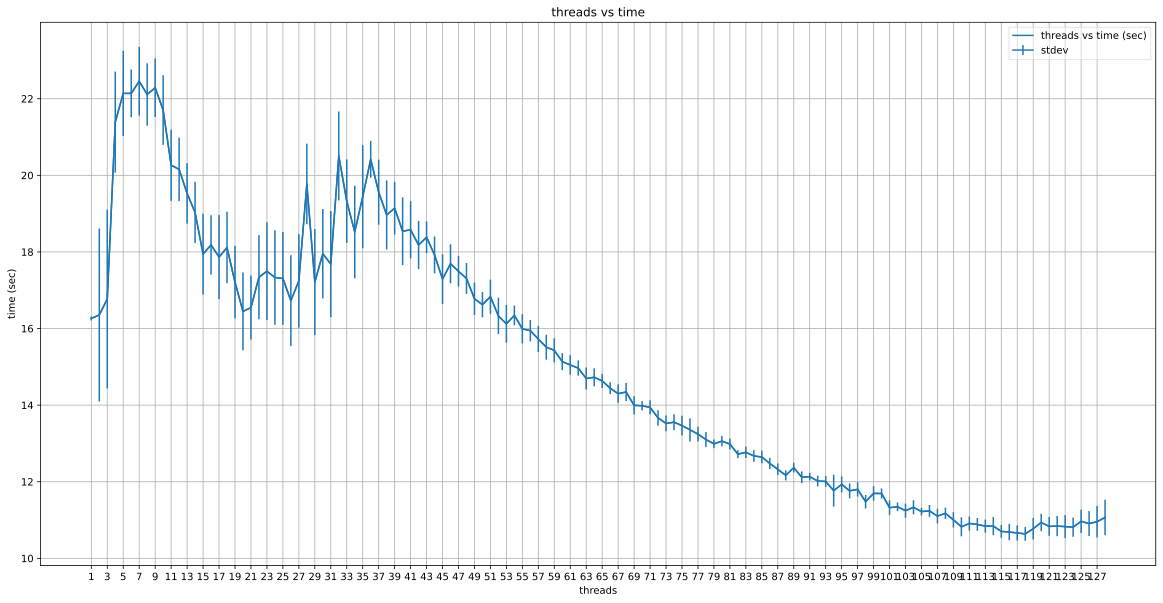

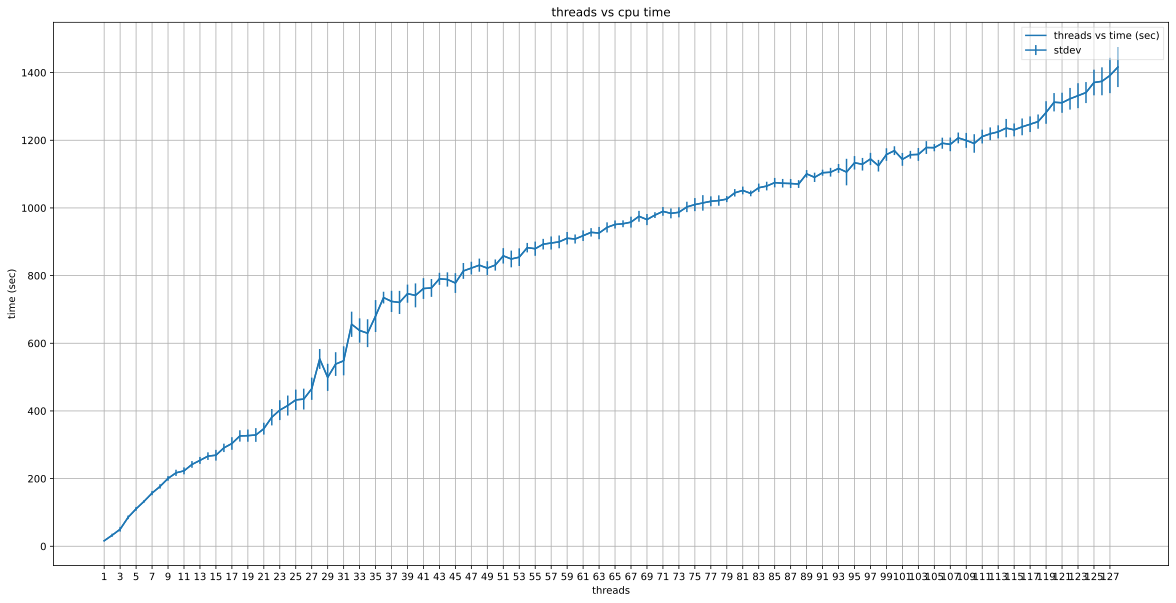

In [6]:
def graph_data(testing_params, mean_dict, stdev_dict, x_axis_title, y_axis_title, graph_title, text_labels=False):
    """
    Uses pyplot to graph the data given the mean and standard deviation of data.
    
    Parameters
    ----------
    testing_params : list
        This is a list of the testing parameters, which is used for the axis construction.
    mean_dict : dict
    stdev_dict : dict
    x_axis_title : str
    y_axis_title : str
    graph_title : str
    text_labels : bool
        This is a boolean parameter for if the testing parameters are text. If they are text, then
        it will set each tick mark on the x-axis to be a label in testing_params.
    """
    
    lists = sorted(mean_dict.items())
    lists_stdev = sorted(stdev_dict.items())
    x, y = zip(*lists)
    x_stdev, y_stdev = zip(*lists_stdev)

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axis_title)
    ax.set_title(graph_title)
    ax.grid(True)
    
    if text_labels:
        xtick_spacer = np.arange(0, len(testing_params), 1)
        xticks = testing_params
        ax.set_xticks(xtick_spacer)
        ax.set_xticklabels(xticks, rotation='horizontal', fontsize=18)
    elif not text_labels:
        #If there are a lot of ticks, it will reduce for visibility.
        interval = testing_params[1] - testing_params[0]
        if len(testing_params) > 80:
            xticks = np.arange(testing_params[0], testing_params[-1]+interval, interval*2)
        else:
            xticks = np.arange(testing_params[0], testing_params[-1]+interval, interval)
        ax.set_xticks(xticks)
    
    ax.plot(x, y, color='tab:blue', label="{} vs {}".format(x_axis_title, y_axis_title))
    plt.errorbar(x, y, yerr=y_stdev, label='stdev')
    leg = plt.legend(loc='best', ncol=1, mode='expanded', fancybox=False)
    leg.get_frame().set_alpha(0.5)

graph_data(threads_numbers, threads_dict_mean, threads_dict_stdev, "threads", "time (sec)", "threads vs time")
graph_data(cpu_threads_numbers, cpu_threads_dict_mean, cpu_threads_dict_stdev, "threads", "time (sec)", "threads vs cpu time")